In [1]:
import pandas as pd
import numpy as np
import math
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.externals import joblib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

In [2]:
#read trips data and join it with weather and public holidays dataset
trips = pd.read_csv('../data/modelInput/flowPerHourAndStation.csv')
additional_features = pd.read_csv('../data/modelInput/additionalFeatures.csv')
trips = trips.merge(additional_features, how='left', on=('date_hour'))
del additional_features

stations = pd.read_csv('../data/modelInput/stations_201505_201611.csv')
trips = trips.merge(stations, how='left', on=('station_id'))

trips['date_hour'] = trips['date_hour'].apply(pd.Timestamp) 
trips = trips.set_index('date_hour')

In [3]:
trips.columns

Index(['station_id', 'arrivals', 'departures', 'flow', 'apparentTemperature',
       'cloudCover', 'dewPoint', 'humidity', 'icon', 'precipAccumulation',
       'precipIntensity', 'precipProbability', 'precipType', 'pressure',
       'summary', 'temperature', 'uvIndex', 'visibility', 'windBearing',
       'windSpeed', 'date', 'hour', 'weekday', 'month', 'year',
       'holiday_description', 'is_holiday', 'is_weekend',
       'is_weekend_or_holiday', 'station_name', 'latitude', 'longitude',
       'first_used', 'last_used', 'latitude_pca', 'longitude_pca'],
      dtype='object')

In [4]:
features = ['latitude_pca', 'longitude_pca',
            'apparentTemperature', 'dewPoint', 'humidity', 'precipIntensity',
            'precipProbability', 'pressure', 'temperature',
            'visibility', 'windBearing', 'windSpeed', 'hour',
            'weekday', 'is_holiday', 'is_weekend', 'is_weekend_or_holiday']

#Split the dataset at 2016-5-1 into training and test data
test_begin_date = pd.Timestamp(2016, 5, 1)

X_train = trips[:test_begin_date][features]
X_test = trips[test_begin_date:][features]
y_train = trips[:test_begin_date]['departures']
y_test = trips[test_begin_date:]['departures']

#create a reduced dataset for parameter optimization
X_train_reduced, y_train_reduced = shuffle(X_train, y_train, n_samples=100000, random_state=42)

#training and test set for the final model
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print('Training set size: ', X_train.shape[0])
print('Test set size: ', X_test.shape[0])
print('Reduced training set size: ', X_train_reduced.shape[0])

Training set size:  1045415
Test set size:  611184
Reduced training set size:  100000


In [5]:
#Creates a XGBoost model from the parameters given in the sklearn wrapper
def train_XGBModel(model, X_train, y_train, X_test, y_test, learning_rate=.005):
    #get parameters from slearn wrapper
    xgb_param = model.get_xgb_params()
    
    #set parameters for native XGBoost
    xgb_param['eval_metric'] = 'rmse'
    xgb_param['learning_rate'] = learning_rate
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    booster = xgb.train(xgb_param,
                        dtrain,
                        num_boost_round=100000,
                        evals=watchlist,
                        early_stopping_rounds=100,
                        verbose_eval=500)
    return booster

In [6]:
#Number of parallel jobs
n_jobs=16

#Number of folds for cross-validation
cv_folds=5

#MSE scorer for cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

#Grid search for given sklearn wrapper and parameters
def grid_search(model, parameters, X_train, y_train):
    gsearch = GridSearchCV(estimator=model, 
                           param_grid=parameters,
                           scoring=mse_scorer,
                           cv=cv_folds, 
                           n_jobs=n_jobs,
                           verbose=2)
    gsearch.fit(X_train, y_train)
    print('Best parameters: ', gsearch.best_params_)
    print('Best score: ', gsearch.best_score_)
    return gsearch.best_estimator_

In [7]:
#sklearn wrapper for XGBoost with initial parameters
basic_model = XGBRegressor(
    booster='gbtree',
    learning_rate=0.1,
    gamma=0,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8, 
    reg_lambda=1,
    reg_alpha=0,
    scale_pos_weight=1,
    objective='count:poisson',
    nthread=16,
    seed=42)

In [8]:
#Evaluate the performance of an XGBooster based on the initial parameters
basic_xgb = train_XGBModel(basic_model, X_train, y_train, X_test, y_test, learning_rate=.1)

[0]	train-rmse:2.16649	valid-rmse:2.51317
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:1.41575	valid-rmse:1.66613
[1000]	train-rmse:1.36041	valid-rmse:1.6358
Stopping. Best iteration:
[1367]	train-rmse:1.34046	valid-rmse:1.62815



In [9]:
dtest = xgb.DMatrix(X_test)
y_predict = basic_xgb.predict(dtest)
print('Results on test set')
print('Root mean squared error: %2.3f' % math.sqrt(mean_squared_error(y_test, y_predict)))
print('R^2 score: %2.3f' % r2_score(y_test, y_predict))

Results on test set
Root mean squared error: 1.628
R^2 score: 0.549


In [10]:
#Grid search starts here
param_test_1 = {
 'max_depth': [3, 5, 7, 9],
 'min_child_weight': [1, 4, 7, 10, 13]
}

basic_model.set_params(n_estimators=500)
best_model_1 = grid_search(basic_model, param_test_1, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed: 29.7min finished


Best parameters:  {'max_depth': 5, 'min_child_weight': 4}
Best score:  -1.85951052044


In [11]:
param_test_2 = {
 'max_depth': [4, 5, 6],
 'min_child_weight': [2.5, 4, 5.5]
}

best_model_2 = grid_search(best_model_1, param_test_2, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  3.6min
[Parallel(n_jobs=16)]: Done  37 out of  45 | elapsed: 11.4min remaining:  2.5min
[Parallel(n_jobs=16)]: Done  45 out of  45 | elapsed: 11.9min finished


Best parameters:  {'max_depth': 5, 'min_child_weight': 4}
Best score:  -1.85951052044


In [12]:
param_test_3 = {
 'gamma': [i/10.0 for i in range(0, 11)]
}

best_model_3 = grid_search(best_model_2, param_test_3, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  4.6min
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed: 13.9min remaining:   47.9s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed: 14.0min finished


Best parameters:  {'gamma': 0.7}
Best score:  -1.85528066365


In [13]:
param_test_4 = {
 'subsample': [.4, .6, .8, 1],
 'colsample_bytree': [.4, .6, .8, 1]
}

best_model_4 = grid_search(best_model_3, param_test_4, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed: 18.2min finished


Best parameters:  {'colsample_bytree': 0.8, 'subsample': 0.8}
Best score:  -1.85528066365


In [14]:
param_test_5 = {
 'subsample': [.7, .8, .9],
 'colsample_bytree': [.7, .8, .9]
}

best_model_5 = grid_search(best_model_4, param_test_5, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done  37 out of  45 | elapsed: 11.6min remaining:  2.5min
[Parallel(n_jobs=16)]: Done  45 out of  45 | elapsed: 11.8min finished


Best parameters:  {'colsample_bytree': 0.9, 'subsample': 0.8}
Best score:  -1.85524034304


In [15]:
param_test_6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

best_model_6 = grid_search(best_model_5, param_test_6, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=16)]: Done   7 out of  25 | elapsed:  4.2min remaining: 10.9min
[Parallel(n_jobs=16)]: Done  20 out of  25 | elapsed:  6.5min remaining:  1.6min
[Parallel(n_jobs=16)]: Done  25 out of  25 | elapsed:  6.8min finished


Best parameters:  {'reg_alpha': 1e-05}
Best score:  -1.85524037221


In [16]:
param_test_7 = {
 'reg_alpha': [1e-6, 1e-5, 1e-4]
}

best_model_7 = grid_search(best_model_6, param_test_7, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=16)]: Done   8 out of  15 | elapsed:  3.5min remaining:  3.1min
[Parallel(n_jobs=16)]: Done  15 out of  15 | elapsed:  3.9min finished


Best parameters:  {'reg_alpha': 0.0001}
Best score:  -1.85421472259


In [17]:
#Grid search done. Train and evaluate final model.
final_model = train_XGBModel(best_model_7, X_train, y_train, X_test, y_test, learning_rate=.005)

[0]	train-rmse:2.20679	valid-rmse:2.56288
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:1.72697	valid-rmse:1.98394
[1000]	train-rmse:1.59344	valid-rmse:1.83833
[1500]	train-rmse:1.51442	valid-rmse:1.76011
[2000]	train-rmse:1.46283	valid-rmse:1.71197
[2500]	train-rmse:1.42884	valid-rmse:1.68218
[3000]	train-rmse:1.40375	valid-rmse:1.66179
[3500]	train-rmse:1.3867	valid-rmse:1.64906
[4000]	train-rmse:1.37265	valid-rmse:1.63963
[4500]	train-rmse:1.36106	valid-rmse:1.63224
[5000]	train-rmse:1.34978	valid-rmse:1.62461
[5500]	train-rmse:1.34055	valid-rmse:1.61896
[6000]	train-rmse:1.33271	valid-rmse:1.61503
[6500]	train-rmse:1.32568	valid-rmse:1.61173
[7000]	train-rmse:1.31933	valid-rmse:1.60901
[7500]	train-rmse:1.31321	valid-rmse:1.60662
[8000]	train-rmse:1.30739	valid-rmse:1.60426
[8500]	train-rmse:1.30221	valid-rmse:1.60206
[9000]	train-rmse:1.29776	valid-rmse:1.60039
[950

In [18]:
final_model.save_model('../models/boosterDepartures.xgbm')

In [19]:
y_predict = final_model.predict(dtest)
print('Results on test set')
print('Root mean squared error: %2.3f' % math.sqrt(mean_squared_error(y_test, y_predict)))
print('R^2 score: %2.3f' % r2_score(y_test, y_predict))

Results on test set
Root mean squared error: 1.584
R^2 score: 0.573


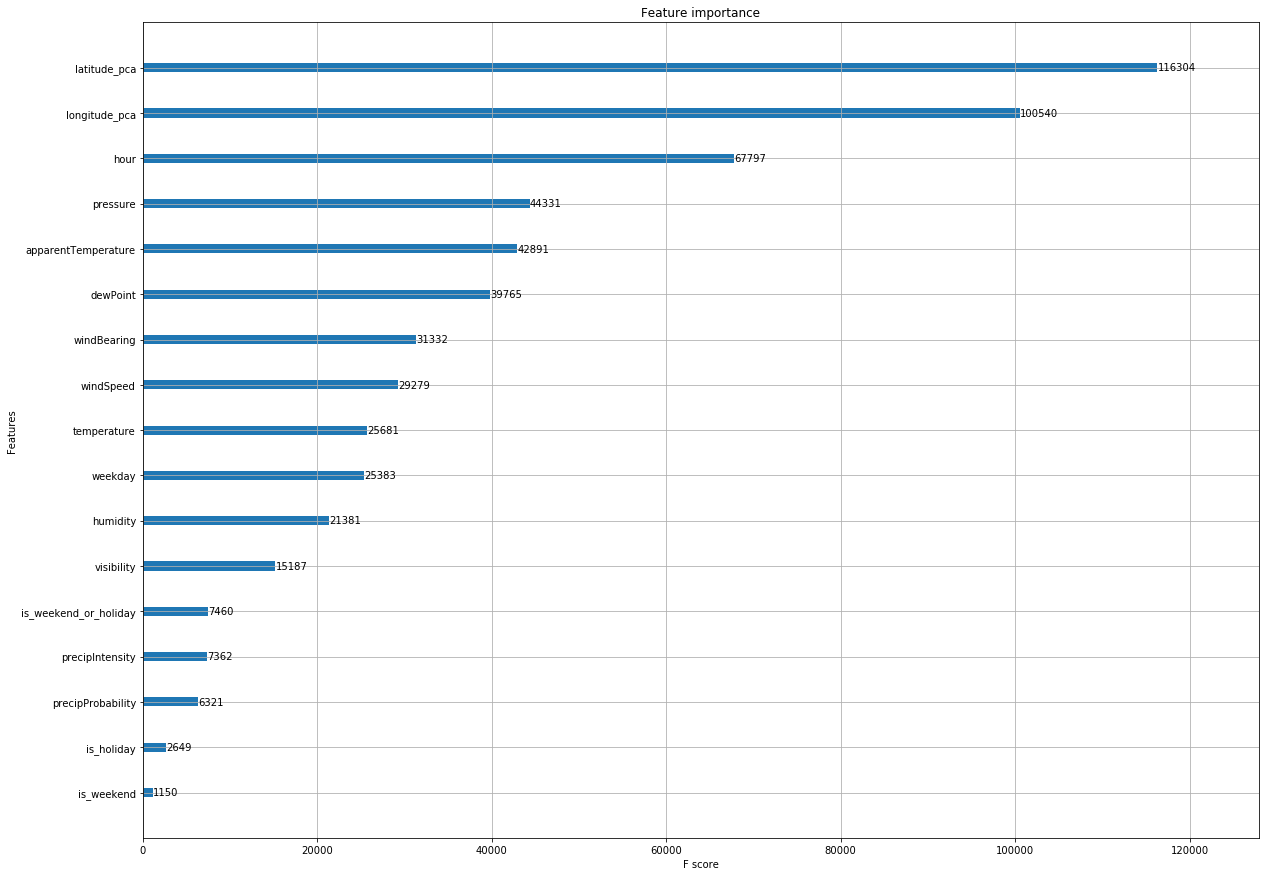

In [20]:
xgb.plot_importance(final_model)